<a href="https://colab.research.google.com/github/jamessutton600613-png/GC/blob/main/Another_copy_of_Untitled272.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

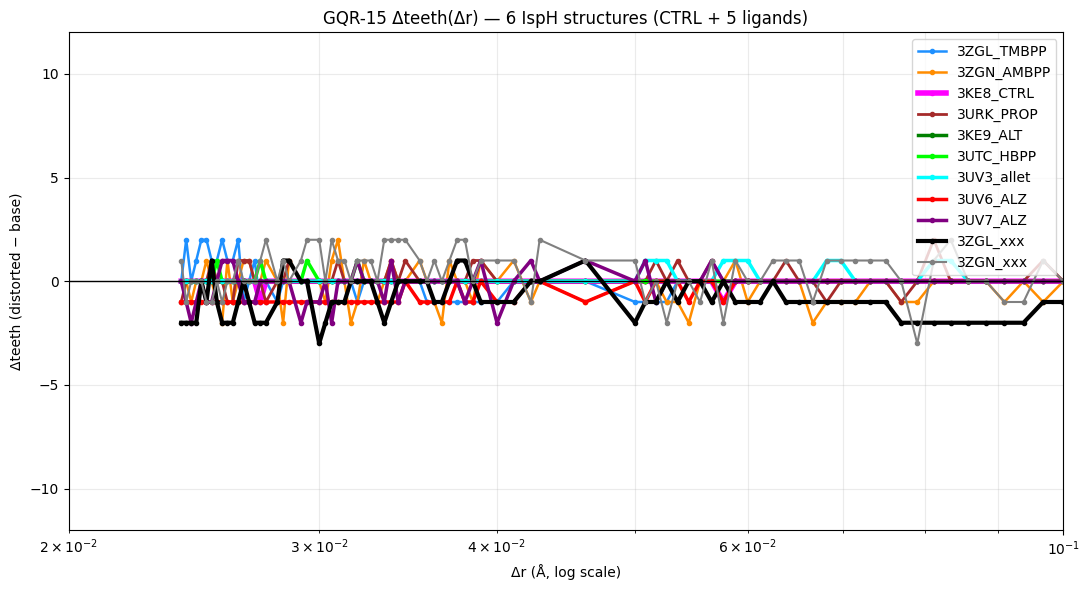

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Directory containing your comb NPZs
LAP_DIR = Path("/content/")

# All six structures
paths = {
    "3ZGL_TMBPP": LAP_DIR / "3ZGL_TMBPP_comb_sto3g.npz",
    "3ZGN_AMBPP": LAP_DIR / "3ZGN_AMBPP_comb_sto3g.npz",
    "3KE8_CTRL":  LAP_DIR / "3KE8_HMBPP_comb_sto3g.npz",
    "3URK_PROP":  LAP_DIR / "3URK__alt_comb_sto3g.npz",
    "3KE9_ALT":   LAP_DIR / "3KE9__alt_comb_sto3g.npz",
    "3UTC_HBPP":  LAP_DIR / "3UTC__alt_comb_sto3g.npz",
    "3UV3_allet": LAP_DIR / "3UV3_alt_comb_sto3g.npz",
    "3UV6_ALZ":   LAP_DIR / "3UV6_alt_comb_sto3g.npz",
    "3UV7_ALZ":  LAP_DIR / "3UV7_alt_comb_sto3g.npz",
    "3ZGL_xxx":  LAP_DIR / "3ZGL_TMBPP_shear_sto3g.npz",
    "3ZGN_xxx":  LAP_DIR / "3ZGN_AMBPP_shear_sto3g.npz",
}

# Same NBINS_LIST and parameters as earlier STO-3G runs
BINS_LIST = [
    1,3,5,7,9,10,11,12,13,14,15,16,17,18,19,
    20,21,22,23,24,25,26,27,28,29,
    30,31,32,33,34,35,36,37,38,39,
    40,41,42,43,44,45,46,47,48,49,
    50,51,52,53,54,55,56,57,58,59,
    60,65,70,71,73,75,77,78,79,80,
    81,82,83,84,85,87,88,89,90,
    91,92,93,94,95,96,97,98,99,100,
    102,103,105,106,107,109,
    110,111,112,113,114,115,116,117,118,119,120,
    121,122,123,124,125
]
L_EFF = 3.0
TRAP_THRESHOLD = 1e-9

def count_traps(mask: np.ndarray) -> int:
    """Count contiguous runs of True in a boolean mask."""
    n = len(mask)
    i = 0
    k = 0
    inside = False
    while i < n:
        if mask[i] and not inside:
            k += 1
            inside = True
        elif not mask[i] and inside:
            inside = False
        i += 1
    return k

def dteeth_from_comb_npz(path: Path):
    """Rebuild Δteeth(Δr) from a comb NPZ with kappa_base/mode."""
    d = np.load(path, allow_pickle=True)
    kb = d["kappa_base"].ravel()
    km = d["kappa_mode"].ravel()
    kmin = min(float(kb.min()), float(km.min()))
    kmax = max(float(kb.max()), float(km.max()))

    dr_list = []
    dt_list = []
    for nb in BINS_LIST:
        edges = np.linspace(kmin, kmax, nb+1)
        hb,_ = np.histogram(kb, bins=edges, density=True)
        hm,_ = np.histogram(km, bins=edges, density=True)

        mask_b = hb < TRAP_THRESHOLD
        mask_m = hm < TRAP_THRESHOLD

        n_b = count_traps(mask_b)
        n_m = count_traps(mask_m)

        dr = L_EFF / nb
        dr_list.append(dr)
        dt_list.append(n_m - n_b)

    return np.array(dr_list), np.array(dt_list)

# Compute curves for all six
curves = {}
for label, p in paths.items():
    if not p.exists():
        print(f"[WARN] Missing {p}")
        continue
    dr, dt = dteeth_from_comb_npz(p)
    curves[label] = (dr, dt)

# Plot composite, zoom Δr = 0.02–0.10 Å
plt.figure(figsize=(11,6))

colors = {
    "3ZGL_TMBPP": "dodgerblue",
    "3ZGN_AMBPP": "darkorange",
    "3KE8_CTRL":  "magenta",   # CTRL
    "3URK_PROP":  "brown",
    "3KE9_ALT":   "green",
    "3UTC_HBPP":  "lime",
    "3UV3_allet": "cyan",
    "3UV6_ALZ":   "red",
    "3UV7_ALZ":  "purple",
    "3ZGL_xxx":  "black",
    "3ZGN_xxx":  "grey", # Added to match paths
}
linewidths = {
    "3ZGL_TMBPP": 1.8,
    "3ZGN_AMBPP": 1.8,
    "3KE8_CTRL":  4.0,   # emphasise control
    "3URK_PROP":  2.0,
    "3KE9_ALT":   2.5,
    "3UTC_HBPP":  2.5,
    "3UV3_allet":  2.5,
    "3UV6_ALZ":   2.5,
    "3UV7_ALZ":  2.5,
    "3ZGL_xxx": 3,
    "3ZGN_xxx": 1.5, # Added to match paths
    }

for label, (dr, dt) in curves.items():
    idx = np.argsort(dr)
    dr_sorted = dr[idx]
    dt_sorted = dt[idx]
    # Zoom region 0.02–0.10 Å
    mask = (dr_sorted >= 2e-2) & (dr_sorted <= 1e-1)
    plt.plot(
        dr_sorted[mask],
        dt_sorted[mask],
        "-o",
        ms=3,
        color=colors[label],
        lw=linewidths[label],
        label=label,
    )

plt.axhline(0, color="k", lw=1)
plt.xscale("log")
plt.xlim(2e-2, 1e-1)
plt.ylim(-12, 12)
plt.xlabel("Δr (Å, log scale)")
plt.ylabel("Δteeth (distorted − base)")
plt.title("GQR-15 Δteeth(Δr) — 6 IspH structures (CTRL + 5 ligands)")
plt.grid(True, which="both", alpha=0.25)
plt.legend()
plt.tight_layout()
plt.show()